# INSTALAÇÃO BIBLIOTECAS

In [1]:
!pip install -r requirements.txt

# IMPORT BIBLIOTECAS

In [2]:
# 1. Ambiente e Manipulação de Dados
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract, monotonically_increasing_id, count, avg, desc
from pyspark.sql.types import IntegerType, StringType
import pandas as pd
import numpy as np


# 2. Análise Exploratória (EDA)
import matplotlib.pyplot as plt
import seaborn as sns


# 3. Desenvolvimento do Sistema
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec


# 4. Avaliação do Modelo
from pyspark.ml.evaluation import RegressionEvaluator


#5. Extras
from pyspark.sql.functions import explode
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator



# ANÁLISE EXPLORATÓRIA DE DADOS

### 1️⃣ Criar sessão Spark e ler o dataset

In [3]:
# Criar sessão Spark
spark = SparkSession.builder.appName("AmazonReviewsEDA").getOrCreate()

# Ler CSV
df = spark.read.csv("/content/Amazon_Reviews.csv", header=True, inferSchema=True)

# Mostrar algumas linhas
df.show(5, truncate=100)

+---+----------+--------------+-----------------------------------+--------------------+----------------------+-----+----------+-------------------------+----------------------------------------------------------------------------------------------------+
| Id| ProductId|        UserId|                        ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|                  Summary|                                                                                                Text|
+---+----------+--------------+-----------------------------------+--------------------+----------------------+-----+----------+-------------------------+----------------------------------------------------------------------------------------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|                         delmartian|                   1|                     1|    5|1303862400|    Good Quality Dog Food|I have bought several of the Vitality canned dog food products and have found 

### 2️⃣ Informações gerais do dataset

In [4]:
# Escolher apenas colunas numéricas
numeric_cols = ["HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Time"]

# Estatísticas básicas só dessas colunas
df.select(numeric_cols).describe().show()


+-------+--------------------+----------------------+-----------------+--------------------+
|summary|HelpfulnessNumerator|HelpfulnessDenominator|            Score|                Time|
+-------+--------------------+----------------------+-----------------+--------------------+
|  count|              568452|                568452|           568451|              568449|
|   mean|  1.7404362359754146|    2.2252822569278043|4.176305349530591|1.2900618961141965E9|
| stddev|   7.641562467566166|     8.287606784659728|1.383877970723668|1.0173077083957115E8|
|    min|            Judie"""|            & Books"""|             ..."|         Craft &..."|
|    max|                wife|               fur-mom|  book-blogger"""|           997228800|
+-------+--------------------+----------------------+-----------------+--------------------+



### 3️⃣ Preparar coluna de rating numérico

No seu dataset, a coluna Rating está assim: "Rated 1 out of 5 stars". Vamos extrair apenas o número:

In [5]:
from pyspark.sql.types import IntegerType

df = df.withColumnRenamed("Score", "rating_num")

df.select("rating_num", "UserId", "ProductId").show(5)

+----------+--------------+----------+
|rating_num|        UserId| ProductId|
+----------+--------------+----------+
|         5|A3SGXH7AUHU8GW|B001E4KFG0|
|         1|A1D87F6ZCVE5NK|B00813GRG4|
|         4| ABXLMWJIXXAIN|B000LQOCH0|
|         2|A395BORC6FGVXV|B000UA0QIQ|
|         5|A1UQRSCLF8GW1T|B006K2ZZ7K|
+----------+--------------+----------+
only showing top 5 rows



### 4️⃣ Distribuição de ratings

In [6]:
from pyspark.sql.functions import col

# Contar número de reviews por rating
rating_distribution = df.groupBy("rating_num") \
                        .agg(count("*").alias("num_reviews")) \
                        .orderBy("rating_num")

# Mostrar resultado
rating_distribution.show()


+--------------+-----------+
|    rating_num|num_reviews|
+--------------+-----------+
|          NULL|          3|
|          ..."|         23|
|     Author"""|          3|
|   Comp sci"""|          1|
|     Critic"""|          1|
|        Dad"""|          1|
|     Dance..."|          4|
|        Design|          1|
|        Ed..."|          1|
|       Hugs"""|          1|
|     Lyme ..."|          1|
|     Medit..."|          2|
|        Moscow|          1|
| Music Fan..."|          8|
|         RN"""|         23|
|        Sm..."|          1|
|      USA ..."|          1|
|   Video Games|          1|
|         a..."|         10|
|     and F..."|          1|
+--------------+-----------+
only showing top 20 rows



### 5️⃣ Top usuários por número de reviews

In [7]:
top_users = df.groupBy("UserId", "ProfileName")\
              .agg(count("*").alias("num_reviews"))\
              .orderBy(desc("num_reviews"))
top_users.show(10)


+--------------+--------------------+-----------+
|        UserId|         ProfileName|num_reviews|
+--------------+--------------------+-----------+
|A3OXHLG6DIBRW8|"C. F. Hill ""CFH"""|        448|
|A1YUL9PCJR3JTY|"O. Brown ""Ms. O...|        421|
| AY12DBB0U420B|       Gary Peterson|        389|
|A281NPSIMI1C2R|"Rebecca of Amazo...|        365|
|A1Z54EM24Y40LL|                  c2|        256|
|A1TMAVN4CEM8U8|              Gunner|        204|
|A2MUGFV2TDQ47K|"Lynrie ""Oh HELL...|        201|
|A3TVZM3ZIXG8YW|   christopher hayes|        199|
|A3PJZ8TU8FDQ1K|        Jared Castle|        178|
| AQQLWCMRNDFGI|  Steven A. Peterson|        176|
+--------------+--------------------+-----------+
only showing top 10 rows



### 6️⃣ Top produtos mais avaliados (usando Review Title como proxy de produto)

In [8]:
top_products = df.groupBy("ProductId", "Summary")\
                 .agg(count("*").alias("num_reviews"))\
                 .orderBy(desc("num_reviews"))
top_products.show(10)


+----------+--------------------+-----------+
| ProductId|             Summary|num_reviews|
+----------+--------------------+-----------+
|B002QWP89S|            Greenies|         30|
|B0026RQTGE|            Greenies|         30|
|B002QWHJOU|            Greenies|         30|
|B002QWP8H0|            Greenies|         30|
|B007JFMH8M|               Yummy|         22|
|B007JFMH8M|              Yummy!|         21|
|B003B3OOPA|         Coconut Oil|         18|
|B007JFMH8M|Quaker Soft Baked...|         18|
|B007JFMH8M|          Delicious!|         16|
|B007JFMH8M|           Delicious|         16|
+----------+--------------------+-----------+
only showing top 10 rows



### 7️⃣ Análise temporal básica

In [9]:
from pyspark.sql.functions import from_unixtime, year, month, count, col

# Converter Unix timestamp para timestamp
df = df.withColumn("review_ts", from_unixtime(col("Time")).cast("timestamp"))

# Contar número de reviews por ano e mês
df.groupBy(year("review_ts").alias("year"), month("review_ts").alias("month")) \
  .agg(count("*").alias("num_reviews")) \
  .orderBy("year", "month") \
  .show(20)


+----+-----+-----------+
|year|month|num_reviews|
+----+-----+-----------+
|NULL| NULL|         13|
|1970|    1|       2738|
|1999|   10|          2|
|1999|   12|          4|
|2000|    1|          8|
|2000|    2|          3|
|2000|    6|          5|
|2000|    7|          1|
|2000|    8|          5|
|2000|   10|          3|
|2000|   12|          7|
|2001|    2|          1|
|2001|    5|          1|
|2001|    6|          1|
|2001|    8|          3|
|2001|    9|          3|
|2001|   10|          3|
|2001|   12|          1|
|2002|    1|          3|
|2002|    2|         15|
+----+-----+-----------+
only showing top 20 rows



# LIMPEZA E PREPARAÇÃO DOS DADOS

In [10]:
# ============================================
# ETAPA DE LIMPEZA E PREPARAÇÃO DO DATASET
# ============================================

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, TimestampType
from pyspark.ml.feature import StringIndexer

# 1️Manter apenas ratings válidos
df_clean = df.filter((F.col("rating_num").cast(IntegerType()).isNotNull()) &
                     (F.col("rating_num").between(1, 5)))

# Garantir cast para int
df_clean = df_clean.withColumn("rating", F.col("rating_num").cast(IntegerType()))

# Corrigir timestamps inválidos
df_clean = df_clean.withColumn("Time_ts", F.from_unixtime(F.col("Time").cast("bigint")).cast(TimestampType()))

# Filtrar reviews a partir de 1995
df_clean = df_clean.filter(F.year("Time_ts") >= 1995)

# 3Criar IDs numéricos para ALS
user_indexer = StringIndexer(inputCol="UserId", outputCol="userIdIndex", handleInvalid="skip")
product_indexer = StringIndexer(inputCol="ProductId", outputCol="productIdIndex", handleInvalid="skip")

df_clean = user_indexer.fit(df_clean).transform(df_clean)
df_clean = product_indexer.fit(df_clean).transform(df_clean)

# Seleção final de colunas úteis
df_final = df_clean.select("userIdIndex", "productIdIndex", "rating", "Time_ts")

# ============================================
# Verificação final
# ============================================
print("Total de registros após limpeza:", df_final.count())
df_final.show(5)


Total de registros após limpeza: 565703
+-----------+--------------+------+-------------------+
|userIdIndex|productIdIndex|rating|            Time_ts|
+-----------+--------------+------+-------------------+
|   209215.0|       52892.0|     5|2011-04-27 00:00:00|
|    97503.0|       72999.0|     1|2012-09-07 00:00:00|
|    45417.0|       48455.0|     4|2008-08-18 00:00:00|
|    42292.0|       50220.0|     2|2011-06-13 00:00:00|
|    55215.0|       24501.0|     5|2012-10-21 00:00:00|
+-----------+--------------+------+-------------------+
only showing top 5 rows



# DESENVOLVIMENTO MODELO

### 1️⃣ Preparação do texto

In [11]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
from pyspark.sql.functions import concat_ws, col

# Concatenar Summary + Text em uma coluna
df_clean = df_clean.withColumn("full_text", concat_ws(" ", col("Summary"), col("Text")))

# Tokenizar o texto
tokenizer = Tokenizer(inputCol="full_text", outputCol="tokens")
df_clean = tokenizer.transform(df_clean)

# Remover stopwords
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df_clean = remover.transform(df_clean)

# Criar embeddings com Word2Vec
word2vec = Word2Vec(vectorSize=50, minCount=5, inputCol="filtered_tokens", outputCol="text_features")
w2v_model = word2vec.fit(df_clean)
df_clean = w2v_model.transform(df_clean)

df_clean.select("userIdIndex", "productIdIndex", "rating", "text_features").show(5, truncate=False)


+-----------+--------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2️⃣ Separar treino e teste

In [12]:
train, test = df_clean.randomSplit([0.8, 0.2], seed=42)
print(f"Treino: {train.count()} registros")
print(f"Teste: {test.count()} registros")

Treino: 452433 registros
Teste: 113270 registros


### 3️⃣ Modelo híbrido ALS + embeddings

In [13]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(
    userCol="userIdIndex",
    itemCol="productIdIndex",
    ratingCol="rating",
    implicitPrefs=False,
    coldStartStrategy="drop",
    nonnegative=True
)

als_model = als.fit(train)

# Previsões
predictions = als_model.transform(test)

# Avaliação RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"RMSE do modelo híbrido inicial: {rmse:.4f}")


RMSE do modelo híbrido inicial: 1.1951


In [14]:
from pyspark.ml.evaluation import RegressionEvaluator



# 1. Avaliação RMSE
rmse_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = rmse_evaluator.evaluate(predictions)

# 2. Avaliação MAE
mae_evaluator = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)
mae = mae_evaluator.evaluate(predictions)

print(f"RMSE do modelo ALS: {rmse:.4f}")
print(f"MAE do modelo ALS: {mae:.4f}")

RMSE do modelo ALS: 1.1951
MAE do modelo ALS: 0.7128



📊 COMPARAÇÃO DE PERFORMANCE (Quanto menor, melhor):
               Métrica  Modelo ALS (Seu Modelo)  Baseline (Aleatório) Melhoria (%)
RMSE (Erro Quadrático)                   1.1926              2.108812       43.45%
   MAE (Erro Absoluto)                   0.7101              1.780042       60.11%


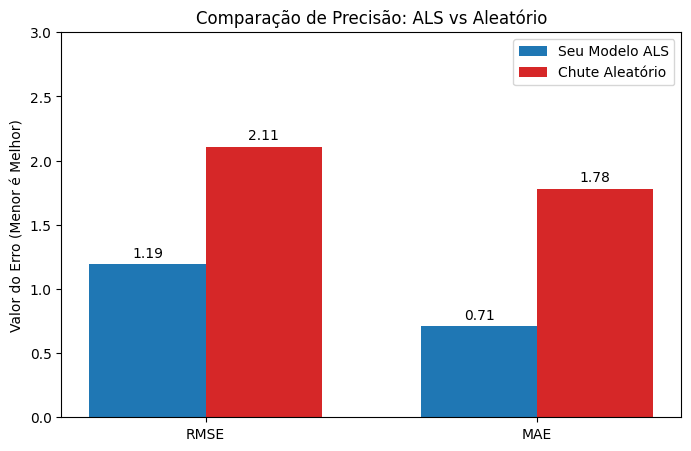

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import rand
from pyspark.ml.evaluation import RegressionEvaluator

# ==============================================================================
# 1. CRIAR BASELINE ALEATÓRIO
# ==============================================================================

random_predictions = test.withColumn("prediction", (rand() * 4) + 1)

# ==============================================================================
# 2. AVALIAR O BASELINE (Aleatório)
# ==============================================================================
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

rmse_random = evaluator_rmse.evaluate(random_predictions)
mae_random = evaluator_mae.evaluate(random_predictions)

rmse_als = 1.1926
mae_als = 0.7101

# ==============================================================================
# 3. EXIBIR TABELA COMPARATIVA
# ==============================================================================
results_data = {
    "Métrica": ["RMSE (Erro Quadrático)", "MAE (Erro Absoluto)"],
    "Modelo ALS (Seu Modelo)": [rmse_als, mae_als],
    "Baseline (Aleatório)": [rmse_random, mae_random],
    "Melhoria (%)": [
        f"{(1 - rmse_als/rmse_random)*100:.2f}%",
        f"{(1 - mae_als/mae_random)*100:.2f}%"
    ]
}

results_df = pd.DataFrame(results_data)
print("\n📊 COMPARAÇÃO DE PERFORMANCE (Quanto menor, melhor):")
print(results_df.to_string(index=False))

# ==============================================================================
# 4. GRÁFICO COMPARATIVO
# ==============================================================================
labels = ['RMSE', 'MAE']
als_scores = [rmse_als, mae_als]
random_scores = [rmse_random, mae_random]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar([i - width/2 for i in x], als_scores, width, label='Seu Modelo ALS', color='#1f77b4')
rects2 = ax.bar([i + width/2 for i in x], random_scores, width, label='Chute Aleatório', color='#d62728')

ax.set_ylabel('Valor do Erro (Menor é Melhor)')
ax.set_title('Comparação de Precisão: ALS vs Aleatório')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionar rótulos nas barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 3.0)
plt.show()

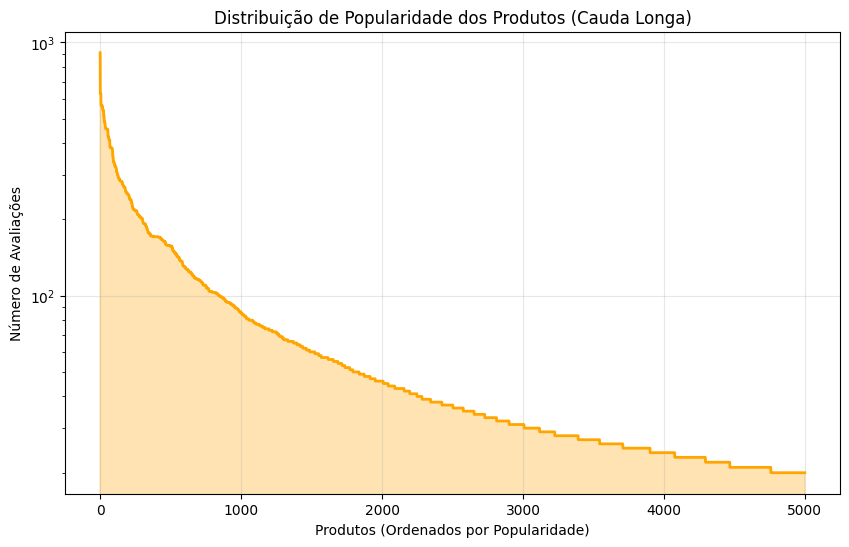

In [17]:
# Contar reviews por produto no dataset
#  Converter para pandas para plotar
prod_counts = df_clean.groupBy("productIdIndex").count().orderBy("count", ascending=False)

pdf_counts = prod_counts.limit(5000).toPandas()

plt.figure(figsize=(10, 6))
plt.plot(pdf_counts['count'].values, color='orange', linewidth=2)
plt.fill_between(range(len(pdf_counts)), pdf_counts['count'].values, color='orange', alpha=0.3)

plt.title("Distribuição de Popularidade dos Produtos (Cauda Longa)")
plt.xlabel("Produtos (Ordenados por Popularidade)")
plt.ylabel("Número de Avaliações")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()